# Fixing the energy map

Let's take a less complicated approach, and assume the energy varies linearly with radius in the image.

We can then re-use our current machinery to calculate the centre and radii of the circles, and use this to get the map.

This can then be compared to the spectra in the paper, and hopefully they agree better

In [6]:
from bragg import find_circle, make_lineout, locate_peaks, sobel_matrix, convolve_image, create_line_histogram
import numpy as np
from histograms import make_histogram
from scipy import ndimage
from scipy.signal import find_peaks
from scipy import constants
import itertools


class LinearEnergyMap(object):

    def __init__(
        self,
        img: np.ndarray,
        num_lineout_points: int,
        dy: int,
        xavg_period: int,
        n_lines: int,
        min_sep: int,
        sobel_shape: tuple[int, int],
        energies: list[float],
    ):
        self.img = img.copy()
        self.dy = dy
        self.num_lineout_points = num_lineout_points
        self.xavg_period = xavg_period
        self.n_lines = n_lines
        self.min_sep = min_sep
        self.sobel_shape = sobel_shape
        self.energies = energies
        self.centre: tuple[float, float] = None
        self.k: float = None
        self.D: float = None
        self.A = 1.0
        self.B = 0.0
        self.energy_calibrated = False

        self.sobel = sobel_matrix(sobel_shape)

        self.convolved_img = convolve_image(self.img, self.sobel)

        self.calculate_map_parameters()

        # make sure r1, r2 and E1, E2 are in the correct order
        if self.r1 > self.r2:
            self.r1, self.r2 = self.r2, self.r1
        self.energies = sorted(self.energies)

        self.create_energy_map()

    def locate_bragg_lines(self, search_ys: list[int]) -> list[list[float]]:
        """Locate Bragg lines in an image. Search for n_lines lines by looking at lineouts
        of the convolved image at 3 y locations, determined by search_ys.

        Lineouts have a width of 2*dy and are averaged over xavg_period pixels.

        Bragg lines must be sepateted by at least min_sep pixels.

        Returns centres of Bragg lines and their radii, in the format [[h1, k1, r1], [h2, k2, r2], ...]

        Returned in descending order of radius (largest radius first)
        """

        assert min(search_ys) - self.dy >= 0, "Lineout would be out of bounds"
        assert (
            max(search_ys) + self.dy < self.img.shape[0]
        ), "Lineout would be out of bounds"


        # get the three lineouts
        lineouts = [
            make_lineout(self.convolved_img, y, self.dy, self.xavg_period) for y in search_ys
        ]

        # locate the peaks in each lineout
        # so, we have [[peak1, peak2], [peak1, peak2], [peak1, peak2]
        peak_locs = [
            locate_peaks(lineout, self.n_lines, self.min_sep)[0] for lineout in lineouts
        ]
        # transpose this list so that we have [[peak1, peak1, peak1], [peak2, peak2, peak2]]
        peak_locs = np.array(peak_locs).T

        bragg_lines = []

        for bragg_line_locs in peak_locs:
            # peak_locs gives the x locations of the peaks in the lineout

            bragg_lines.append(find_circle(*bragg_line_locs, *search_ys))

        return sorted(bragg_lines, key=lambda x: x[2], reverse=True)

    def calculate_map_parameters(self):

        lineout_points = np.linspace(
            self.dy, self.img.shape[0] - 1 - self.dy, self.num_lineout_points, dtype=int
        )
        y_combinations = list(itertools.combinations(lineout_points, 3))

        line_params = np.array(
            [self.locate_bragg_lines(y_comb) for y_comb in y_combinations]
        )

        x_locs = line_params[:, :, 0].flatten()
        y_locs = line_params[:, :, 1].flatten()

        r1s = line_params[:, 0, 2]
        r2s = line_params[:, 1, 2]

        x_med = np.median(x_locs)
        y_med = np.median(y_locs)

        weights = 1 / ((x_locs - x_med) ** 2 + (y_locs - y_med) ** 2)

        x_avg = np.average(x_locs, weights=weights)
        y_avg = np.average(y_locs, weights=weights)

        self.r1 = np.average(r1s, weights=weights[0::2])
        self.r2 = np.average(r2s, weights=weights[1::2])

        self.centre = (x_avg, y_avg)

        E1, E2 = self.energies

        self.A = (E1-E2) / (self.r1 - self.r2)
        self.B = E1 - self.A * self.r1

    def create_energy_map(self):
        indices = np.indices(self.img.shape)

        radii = np.np.np.np.np.np.sqrt((indices[0] - self.centre[1]) ** 2 + (indices[1] - self.centre[0]) ** 2)

        self.energy_map = self.A * radii + self.B
        
    def get_energies(self, locs: np.ndarray):
        """Get energies from array positions"""
        energies = np.array([self.energy_map[int(loc[0]), int(loc[1])] for loc in locs])
        return energies



In [7]:
from bragg import find_circle, make_lineout, locate_peaks, sobel_matrix, convolve_image, create_line_histogram
import numpy as np
from histograms import make_histogram
from scipy import ndimage
from scipy.signal import find_peaks
from scipy import constants
import itertools
from spc import SPC
import matplotlib.pyplot as plt

img = np.load("data/images/image8.npy")

spc = SPC(img, 75, 30, 2)

In [8]:
energies = [1218.5, 1188.0]
from bragg import EnergyMap
energy_map = LinearEnergyMap(spc.img, 5, 200, 20, 2, 100, (25, 25), energies)

In [9]:

spectrum = energy_map.get_energies(spc.all_hit_locations)

bin_centres, hist = make_histogram(spectrum, -1)


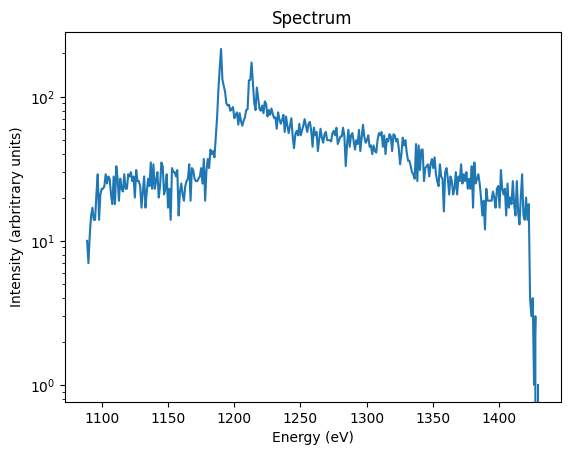

In [10]:
plt.plot(bin_centres, hist)

#plt.vlines(energies, 0, 500, colors="r")
plt.title("Spectrum")
plt.ylabel("Intensity (arbritrary units)")
plt.xlabel("Energy (eV)")
plt.yscale("log")
plt.show()

In [11]:
from spc import SPC
from bragg import EnergyMap
import numpy as np
import matplotlib.pyplot as plt
image_nos = [1, 2, 4, 6, 7, 8, 11, 14, 16, 17, 19] # See Week 3
energies = [1218.5, 1188.0]
all_images = np.array([np.load(f'data/images/image{no}.npy') for no in image_nos])

spcs = []
hit_values = []
hit_locations = []


for i in range(len(all_images)):
    spc = SPC(all_images[i], 75, 30, 2)
    spcs.append(spc)
    hit_values.append(spc.all_hit_values)
    hit_locations.append(spc.all_hit_locations)
    print(f"Finished image {image_nos[i]}")

master_energy_map = LinearEnergyMap(spcs[5].img, 5, 200, 20, 2, 100, (25, 25), energies)

Finished image 1
Finished image 2
Finished image 4
Finished image 6
Finished image 7
Finished image 8
Finished image 11
Finished image 14
Finished image 16
Finished image 17
Finished image 19


In [12]:
all_hit_energies = [master_energy_map.get_energies(hit_locs) for hit_locs in hit_locations]

C:\Users\jwbar\AppData\Local\Temp\ipykernel_6804\923644065.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("jet")


Text(0.5, 1.0, 'All spectra')

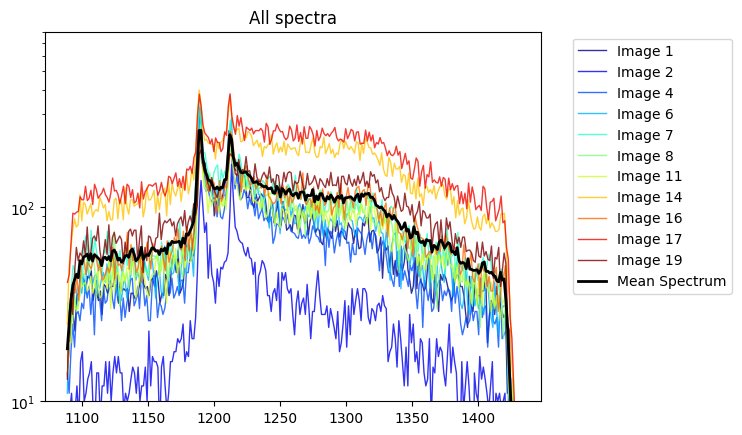

In [21]:
from histograms import make_histogram
import matplotlib

cmap = matplotlib.cm.get_cmap("jet")

colours = [cmap(i) for i in np.linspace(0, 1, len(all_hit_energies))]

all_energy_spectra = []

all_hit_energies = sorted(all_hit_energies, key = lambda x: np.mean(x))

for i in range(len(all_hit_energies)):
    bin_centers, hist = make_histogram(all_hit_energies[i], 250)
    all_energy_spectra.append(hist)
    plt.plot(bin_centers, hist, label = f"Image {image_nos[i]}", c=colours[i], alpha = 0.8, lw = 1)

all_energy_spectra = np.array(all_energy_spectra)
mean_spectrum = np.mean(all_energy_spectra, axis=0)

plt.plot(bin_centers, mean_spectrum, label = "Mean Spectrum", c="black", lw=2)

plt.yscale("log")
plt.ylim(10,800)
#plt.vlines(energies, 0, 10000, colors='r')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("All spectra")

## Improving double hit detection

Let's look at the spc results for all images combined, and see if we can see the second peak corresponding to double hits (it's not visibe on the histogram for a single image)

In [11]:
from spc import SPC
from bragg import EnergyMap
import numpy as np
import matplotlib.pyplot as plt
image_nos = [1, 2, 4, 6, 7, 8, 11, 14, 16, 17, 19] # See Week 3
energies = [1218.5, 1188.0]
all_images = np.array([np.load(f'data/images/image{no}.npy') for no in image_nos])

spcs = []
hit_values = []
hit_locations = []


for i in range(len(all_images)):
    spc = SPC(all_images[i], 200, 30, 4, False)
    spcs.append(spc)
    hit_values.append(spc.all_hit_values)
    hit_locations.append(spc.all_hit_locations)
    print(f"Finished image {image_nos[i]}")

Finished image 1
Finished image 2
Finished image 4
Finished image 6
Finished image 7
Finished image 8
Finished image 11
Finished image 14
Finished image 16
Finished image 17
Finished image 19


n1+n2 = 71506
n2 = 3381


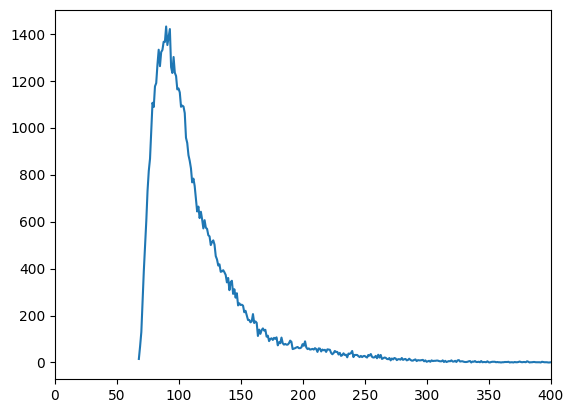

In [17]:
from histograms import make_histogram
bins, hist = make_histogram(np.concatenate(hit_values), -1)

plt.plot(bins, hist)
#plt.yscale("log")
plt.xlim(0,400)
print(f"n1+n2 = {sum(hist)}")
print(f"n2 = {sum(hist[bins > 200])}")

So, we're seeing more double hits than expected (expected is $n_1^2/(2(N-n_1)$). Let's try only using images far from the lines. Note that I've also set the primary threshold high, so that we don't get spurious effects from it

Finished image 1
Finished image 2
Finished image 4
Finished image 6
Finished image 7
Finished image 8
Finished image 11
Finished image 14
Finished image 16
Finished image 17
Finished image 19
n1+n2 = 71506
n2 = 3381


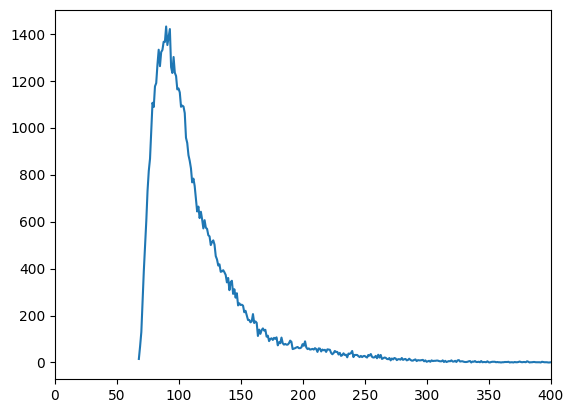

In [1]:
from spc import SPC
from bragg import EnergyMap
import numpy as np
import matplotlib.pyplot as plt
image_nos = [1, 2, 4, 6, 7, 8, 11, 14, 16, 17, 19] # See Week 3
energies = [1218.5, 1188.0]
all_images = np.array([np.load(f'data/images/image{no}.npy') for no in image_nos])

spcs = []
hit_values = []
hit_locations = []


for i in range(len(all_images)):
    spc = SPC(all_images[i], 200, 30, 4, False, image_indices=[(0, 2048), (0, 1200)])
    spcs.append(spc)
    hit_values.append(spc.all_hit_values)
    hit_locations.append(spc.all_hit_locations)
    print(f"Finished image {image_nos[i]}")

from histograms import make_histogram
bins, hist = make_histogram(np.concatenate(hit_values), -1)

plt.plot(bins, hist)
#plt.yscale("log")
plt.xlim(0,400)
print(f"n1+n2 = {sum(hist)}")
print(f"n2 = {sum(hist[bins > 200])}")

(0.0, 300.0)

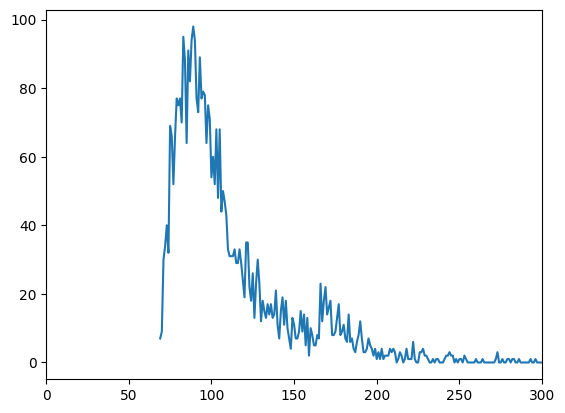

In [8]:
spc = SPC(all_images[5], 165, 30, 4, False)

bins, hist = make_histogram(spc.all_hit_values, -1)

plt.plot(bins, hist)
plt.xlim(0,300)

# Fixing Bragg Maps

## Initial attempt

Finding the equation of a hyperbola through three points

In [2]:
from sympy.parsing.mathematica import parse_mathematica
from sympy import var
from sympy import solve

l1y1, l1y2, y3, l1x1, l1x2, x3, D, E, xc, yc, k = var("y1 y2 y3 x1 x2 x3 D E xc yc k")

solve([-(l1x1 - xc)**2 + (l1y1 - yc)**2/(E)-D**2, -(l1x2 - xc)**2 + (l1y2 - yc)**2/(E)-D**2, -(x3 - xc)**2 + (y3 - yc)**2/(E)-D**2], [xc, yc, D], dict=True)


[{D: -sqrt((E*x1**2 - 2*E*x1*x2 + E*x2**2 - y1**2 + 2*y1*y2 - y2**2)*(E*x1**2 - 2*E*x1*x3 + E*x3**2 - y1**2 + 2*y1*y3 - y3**2)*(E*x2**2 - 2*E*x2*x3 + E*x3**2 - y2**2 + 2*y2*y3 - y3**2))/(2*E*(x1*y2 - x1*y3 - x2*y1 + x2*y3 + x3*y1 - x3*y2)),
  xc: (E*x1**2*y2 - E*x1**2*y3 - E*x2**2*y1 + E*x2**2*y3 + E*x3**2*y1 - E*x3**2*y2 - y1**2*y2 + y1**2*y3 + y1*y2**2 - y1*y3**2 - y2**2*y3 + y2*y3**2)/(2*E*(x1*y2 - x1*y3 - x2*y1 + x2*y3 + x3*y1 - x3*y2)),
  yc: (E*x1**2*x2 - E*x1**2*x3 - E*x1*x2**2 + E*x1*x3**2 + E*x2**2*x3 - E*x2*x3**2 + x1*y2**2 - x1*y3**2 - x2*y1**2 + x2*y3**2 + x3*y1**2 - x3*y2**2)/(2*(x1*y2 - x1*y3 - x2*y1 + x2*y3 + x3*y1 - x3*y2))},
 {D: sqrt((E*x1**2 - 2*E*x1*x2 + E*x2**2 - y1**2 + 2*y1*y2 - y2**2)*(E*x1**2 - 2*E*x1*x3 + E*x3**2 - y1**2 + 2*y1*y3 - y3**2)*(E*x2**2 - 2*E*x2*x3 + E*x3**2 - y2**2 + 2*y2*y3 - y3**2))/(2*E*(x1*y2 - x1*y3 - x2*y1 + x2*y3 + x3*y1 - x3*y2)),
  xc: (E*x1**2*y2 - E*x1**2*y3 - E*x2**2*y1 + E*x2**2*y3 + E*x3**2*y1 - E*x3**2*y2 - y1**2*y2 + y1**2*y3 + y1*

In [29]:
import numpy as np

# These expressions are adjusted, since our coordinate system is different
# Increasing x in the image is decreasing y in the model
# Increasing y in the image is increasing x in the model
def D2(x1, x2, x3, y1, y2, y3, E, k):
    E = E**2 / k**2 - 1
    return np.abs(
        (E * y1**2 - 2 * E * y1 * y2 + E * y2**2 - x1**2 + 2 * x1 * x2 - x2**2)
        * (E * y1**2 - 2 * E * y1 * y3 + E * y3**2 - x1**2 + 2 * x1 * x3 - x3**2)
        * (E * y2**2 - 2 * E * y2 * y3 + E * y3**2 - x2**2 + 2 * x2 * x3 - x3**2)
    ) / ((2 * E * (y1 * x2 - y1 * x3 - y2 * x1 + y2 * x3 + y3 * x1 - y3 * x2))**2)


def yc(x1, x2, x3,y1, y2, y3,  E, k):
    E = E**2 / k**2 - 1
    return (
        E * y1**2 * x2
        - E * y1**2 * x3
        - E * y2**2 * x1
        + E * y2**2 * x3
        + E * y3**2 * x1
        - E * y3**2 * x2
        - x1**2 * x2
        + x1**2 * x3
        + x1 * x2**2
        - x1 * x3**2
        - x2**2 * x3
        + x2 * x3**2
    ) / (2 * E * (y1 * x2 - y1 * x3 - y2 * x1 + y2 * x3 + y3 * x1 - y3 * x2))


def xc(x1, x2, x3, y1, y2, y3, E, k):
    E = E**2 / k**2 - 1
    return (
        E * y1**2 * y2
        - E * y1**2 * y3
        - E * y1 * y2**2
        + E * y1 * y3**2
        + E * y2**2 * y3
        - E * y2 * y3**2
        + y1 * x2**2
        - y1 * x3**2
        - y2 * x1**2
        + y2 * x3**2
        + y3 * x1**2
        - y3 * x2**2
    ) / (2 * (y1 * x2 - y1 * x3 - y2 * x1 + y2 * x3 + y3 * x1 - y3 * x2))

In [30]:

def find_hyperbola(x1,x2,x3,y1,y2,y3,k,E):
    """Finds hyperbola through three points, returns it in the form (xc, yc, D)"""

    x1 = np.float64(x1)
    x2 = np.float64(x2)
    x3 = np.float64(x3)
    y1 = np.float64(y1)
    y2 = np.float64(y2)
    y3 = np.float64(y3)
    k = np.float64(k)
    E = np.float64(E)

    xc_ = xc(x1, x2, x3, y1, y2, y3, k, E)
    yc_ = yc(x1, x2, x3, y1, y2, y3, k, E)
    D2_ = D2(x1, x2, x3, y1, y2, y3, k, E)

    return (xc_, yc_, D2_)

In [31]:
from scipy import constants
from bragg import sobel_matrix, convolve_image, make_lineout, locate_peaks

class HypEnergyMap(object):

    def __init__(
        self,
        img: np.ndarray,
        num_lineout_points: int,
        dy: int,
        xavg_period: int,
        n_lines: int,
        min_sep: int,
        sobel_shape: tuple[int, int],
        energies: list[float],
    ):
        self.img = img.copy()
        self.dy = dy
        self.num_lineout_points = num_lineout_points
        self.xavg_period = xavg_period
        self.n_lines = n_lines
        self.min_sep = min_sep
        self.sobel_shape = sobel_shape
        self.energies = energies
        self.centre: tuple[float, float] = None

        self.two_d = 15.96e-10
        self.k: float = constants.h * constants.c / (self.two_d * constants.e)
        self.D: float = None

        self.sobel = sobel_matrix(sobel_shape)

        self.convolved_img = convolve_image(self.img, self.sobel)

        self.calculate_map_parameters()

        # make sure r1, r2 and E1, E2 are in the correct order
        """if self.r1 > self.r2:
            self.r1, self.r2 = self.r2, self.r1
        self.energies = sorted(self.energies)"""

        # self.create_energy_map()

    def locate_bragg_peaks(self, search_ys: list[int]) -> list[list[float]]:
        """Locate Bragg lines in an image. Search for n_lines lines by looking at lineouts
        of the convolved image at 3 y locations, determined by search_ys.

        Lineouts have a width of 2*dy and are averaged over xavg_period pixels.

        Bragg lines must be sepateted by at least min_sep pixels.

        Returns points that can be used to fit the Bragg line, in the format
        [[line 1 x locations], [line 2 x locations], ...]
        
        Lines are ordered in increasing energy.
        """

        assert min(search_ys) - self.dy >= 0, "Lineout would be out of bounds"
        assert (
            max(search_ys) + self.dy < self.img.shape[0]
        ), "Lineout would be out of bounds"

        # get the three lineouts
        lineouts = [
            make_lineout(self.convolved_img, y, self.dy, self.xavg_period)
            for y in search_ys
        ]

        # locate the peaks in each lineout
        # so, we have [[peak1, peak2], [peak1, peak2], [peak1, peak2]], where the inner
        # lists are the x locations of the peaks for a given y location
        peak_locs = [
            locate_peaks(lineout, self.n_lines, self.min_sep)[0] for lineout in lineouts
        ]
        # transpose this list so that we have [[peak1, peak1, peak1], [peak2, peak2, peak2]]
        peak_locs = np.array(peak_locs).T

        return peak_locs[::-1]

    def calculate_map_parameters(self):

        # define the possible y locations to take lineouts
        lineout_points = np.linspace(
            self.dy, self.img.shape[0] - 1 - self.dy, self.num_lineout_points, dtype=int
        )

        # get all combinations of 3 of these points, and find the x locations of the peaks
        y_combinations = list(itertools.combinations(lineout_points, 3))

        x_positions = np.array(
            [self.locate_bragg_peaks(y_comb) for y_comb in y_combinations]
        )
        
        # for each combination of y locations, calculate the hyperbola parameters

        all_hyp_params = []

        for i, y_comb in enumerate(y_combinations):
            for j, x_comb in enumerate(x_positions[i]):
                hyp_params = find_hyperbola(*x_comb, *y_comb, self.k, self.energies[j])
                all_hyp_params.append(hyp_params)

        print(all_hyp_params)
        return

        x_locs = line_params[:, :, 0].flatten()
        y_locs = line_params[:, :, 1].flatten()

        r1s = line_params[:, 0, 2]
        r2s = line_params[:, 1, 2]

        x_med = np.median(x_locs)
        y_med = np.median(y_locs)

        weights = 1 / ((x_locs - x_med) ** 2 + (y_locs - y_med) ** 2)

        x_avg = np.average(x_locs, weights=weights)
        y_avg = np.average(y_locs, weights=weights)

        self.r1 = np.average(r1s, weights=weights[0::2])
        self.r2 = np.average(r2s, weights=weights[1::2])

        self.centre = (x_avg, y_avg)

    def create_energy_map(self):

        two_d = 15.96e-10

        self.k = constants.h * constants.c / (two_d * constants.e)

        E1 = self.energies[0]
        E2 = self.energies[1]

        D1 = self.r1 / np.sqrt(E1**2 / (self.k**2) - 1)
        D2 = self.r2 / np.sqrt(E2**2 / (self.k**2) - 1)

        self.D = (D1 + D2) / 2

        indices = np.indices(self.img.shape)

        Radii = (
            self.A
            * np.sqrt(
                (indices[0] - self.centre[1]) ** 2 + (indices[1] - self.centre[0]) ** 2
            )
            + self.B
        )

        self.energy_map: np.ndarray = (self.k / self.D) * np.sqrt(Radii**2 + self.D**2)

    def calibrate_energies(self, spectrum):
        """Use a spectrum to improve energy map calibration"""
        self.energy_calibrated = True

        spectrum_x, spectrum_y = make_histogram(spectrum, -1)

        old_peaks = find_peaks(spectrum_y, distance=10)

        # get the energies of the largest 2 peaks
        old_peaks = spectrum_x[np.argsort(spectrum_y[old_peaks[0]])][-2:]

        # Convert these into old radii
        or1, or2 = sorted(self.D * np.sqrt((old_peaks / self.k) ** 2 - 1))
        print(self.r1, self.r2)
        print(or1, or2)
        # or1, or2 = self.r1, self.r2

        # Calculate the shifting constants A and B to get the peaks in the right place
        E1 = self.energies[0]
        E2 = self.energies[1]

        self.A = (
            self.D
            * (np.sqrt(E1**2 / (self.k**2) - 1) - np.sqrt(E2**2 / (self.k**2) - 1))
            / (or1 - or2)
        )
        self.B = self.D * np.sqrt(E1**2 / (self.k**2) - 1) - or1 * self.A

        indices = np.indices(self.img.shape)

        Radii = (
            self.A
            * np.sqrt(
                (indices[0] - self.centre[1]) ** 2 + (indices[1] - self.centre[0]) ** 2
            )
            + self.B
        )

        self.energy_map: np.ndarray = (self.k / self.D) * np.sqrt(Radii**2 + self.D**2)

    def get_energies(self, locs: np.ndarray):
        """Get energies from array positions"""
        print(locs)
        energies = np.array([self.energy_map[int(loc[0]), int(loc[1])] for loc in locs])
        return energies

    def calculate_energy(self, loc: tuple[float, float]):
        """Calculate the energy at a given location"""
        R = (
            self.A
            * np.sqrt((loc[0] - self.centre[1]) ** 2 + (loc[1] - self.centre[0]) ** 2)
            + self.B
        )

        return (self.k / self.D) * np.sqrt(R**2 + self.D**2)


In [32]:
from spc import SPC

img = np.load("data/images/image8.npy")

spc = SPC(img, 75, 30, 2)


In [33]:
import itertools
energies = [1188.0, 1218.5]

em = HypEnergyMap(spc.img, 5, 200, 20, 2, 100, (25, 25), energies)

[(9496.302109964883, 988.1994267066245, 113981639.1030081), (5154.340054409924, 769.5126517131682, 25288749.2018655), (7247.72687773831, 825.7148467457725, 59297640.51141482), (5931.175469612328, 842.7552402295195, 36470405.53815123), (6932.32333098214, 802.9234310624761, 53044231.77434903), (6245.122160460041, 872.3551629980184, 41569308.65206569), (5978.559674946195, 823.9194951459177, 36359432.18484336), (7098.863893140035, 849.1271359891202, 56978218.4575592), (6179.091931700035, 833.2844290556034, 39620778.829709), (7057.372835855465, 847.4283709433995, 56168885.68492878), (6396.751862322844, 824.5110657530131, 43295886.34538939), (7016.638604673245, 848.6784452627511, 55383741.35498672), (5164.964604803793, 896.367764746563, 24530644.61167105), (9045.205213727126, 721.7796360472803, 101550782.33592077), (5609.160559638495, 905.7854683358092, 30686930.269410323), (8182.943257621743, 732.35783955047, 80250043.64889432), (6167.987728624117, 862.3425130694912, 39380568.797971904), (7

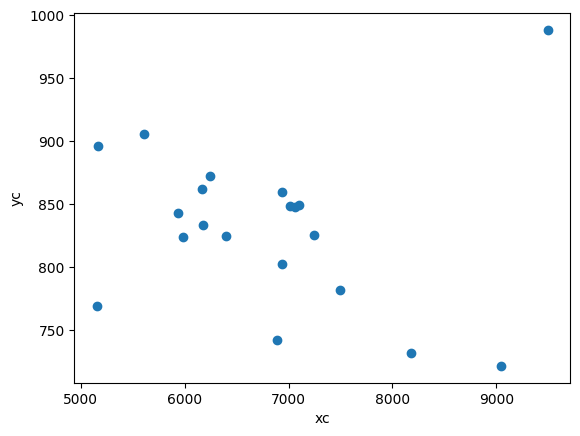

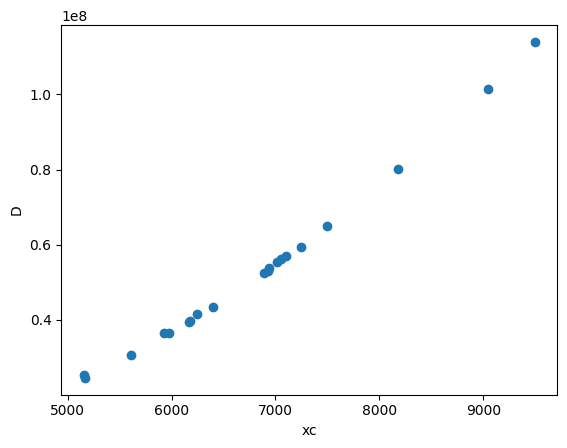

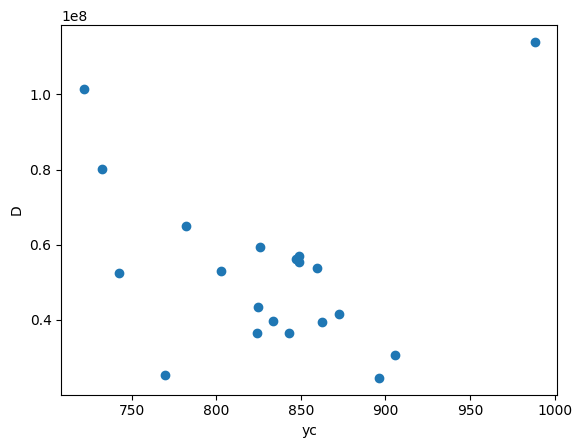

In [36]:
import matplotlib.pyplot as plt
nan = 0
hyp_cs = [(9496.302109964883, 988.1994267066245, 113981639.1030081), (5154.340054409924, 769.5126517131682, 25288749.2018655), (7247.72687773831, 825.7148467457725, 59297640.51141482), (5931.175469612328, 842.7552402295195, 36470405.53815123), (6932.32333098214, 802.9234310624761, 53044231.77434903), (6245.122160460041, 872.3551629980184, 41569308.65206569), (5978.559674946195, 823.9194951459177, 36359432.18484336), (7098.863893140035, 849.1271359891202, 56978218.4575592), (6179.091931700035, 833.2844290556034, 39620778.829709), (7057.372835855465, 847.4283709433995, 56168885.68492878), (6396.751862322844, 824.5110657530131, 43295886.34538939), (7016.638604673245, 848.6784452627511, 55383741.35498672), (5164.964604803793, 896.367764746563, 24530644.61167105), (9045.205213727126, 721.7796360472803, 101550782.33592077), (5609.160559638495, 905.7854683358092, 30686930.269410323), (8182.943257621743, 732.35783955047, 80250043.64889432), (6167.987728624117, 862.3425130694912, 39380568.797971904), (7496.653129293006, 781.9386709364076, 65099464.89987044), (6892.393318049891, 742.5452727896364, 52415910.375721924), (6937.453765469622, 859.6880669042754, 53856461.51461821)]


hyp_cs = np.array(hyp_cs)

plt.scatter(hyp_cs[:, 0], hyp_cs[:, 1])
plt.xlabel("xc")
plt.ylabel("yc")
plt.show()
plt.scatter(hyp_cs[:, 0], hyp_cs[:, 2])
plt.xlabel("xc")
plt.ylabel("D")
plt.show()
plt.scatter(hyp_cs[:, 1], hyp_cs[:, 2])
plt.xlabel("yc")
plt.ylabel("D")
plt.show()

So, it looks like there is a strong trend in xc with D. So, we should introduce another free parameter to allow for some stretching in the x direction. We now have 4 free parameters, so we need either:
- 4 points on one line
- 2 points on both lines

To calculate the parameters. Let's use 2 points from both lines

## Adding another parameter

In [3]:
from sympy.parsing.mathematica import parse_mathematica
from sympy import var
from sympy import solve

l1y1, l1y2, l2y1, l2y2, l1x1, l1x2, l2x1, l2x2, D2, E1, E2, xc, yc, k, Ys = var(
    "l1y1 l1y2 l2y1 l2y2 l1x1 l1x2 l2x1 l2x2 D2 E1 E2 xc yc k Ys"
)

solve1 = solve(
    [
        (l1x1 - xc) ** 2 / (E1) - Ys * (l1y1 - yc) ** 2 - D2,
        (l1x2 - xc) ** 2 / (E1) - Ys * (l1y2 - yc) ** 2 - D2,
    ],
    [xc, yc],
    dict=True
)
solve2 = solve(
      [
        (l2x1 - xc) ** 2 / (E2) - Ys * (l2y1 - yc) ** 2 - D2,
        (l2x2 - xc) ** 2 / (E2) - Ys * (l2y2 - yc) ** 2 - D2,
    ],
    [xc, yc],
    dict=True,
)

In [5]:
from sympy import simplify
xc1, yc1 = simplify(solve1[0][xc]), simplify(solve1[0][yc])
xc2, yc2 = simplify(solve2[0][xc]), simplify(solve2[0][yc])

In [9]:
final = solve([xc1 - xc2, yc1 - yc2], [Ys, D2], dict=True)

MemoryError: 

## Numerical fitting

We can instead try fitting the curve numerically, by taking a series of lineouts across the image

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from spc import SPC
from bragg import EnergyMap, make_lineout, convolve_image, sobel_matrix, locate_peaks
img = np.load("data/images/image8.npy")

spc = SPC(img, 75, 30, 2)

convolved = convolve_image(spc.img, sobel_matrix((25, 25)))

dy = 200
xavg_period = 20
yvals = np.linspace(dy, spc.img.shape[0] - dy, 50, dtype=int)

lineouts = [make_lineout(convolved, y, dy, xavg_period) for y in yvals]

peaks = np.array([locate_peaks(lineout, 2, 100)[0] for lineout in lineouts])


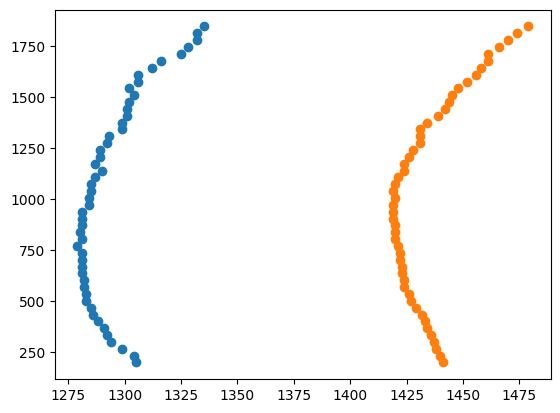

In [3]:
plt.scatter(peaks[:, 0], yvals)
plt.scatter(peaks[:, 1], yvals)

These are definitely hyperbola. So, let's try fitting to them

In [68]:
from scipy.optimize import curve_fit
from scipy import constants

energies = [1218.5, 1188.0]
k = constants.h * constants.c / (15.96e-10 * constants.e)



def hyperbola(Econst, y, xc, yc, D2, Ys):
    """We define Econst = E^2/k^2 - 1"""
    return xc + np.sqrt((1/Econst) * (D2 + Ys * (y - yc) ** 2))

p0 = [50, 750, 1e6, 0.2]
bounds = ([-5000, 600, 5e5, 0], [1000, 1000, 15e6, 1])

Econst1 = energies[0]**2 / k**2 - 1
xvals = peaks[:, 0]
popt1, pcov1 = curve_fit(
    lambda y, xc, yc, D2, Ys: hyperbola(Econst1, y, xc, yc, D2, Ys),
    yvals,
    xvals,
    p0=p0,
    maxfev=10000,
    bounds=bounds
)

Econst2 = energies[1]**2 / k**2 - 1
xvals = peaks[:, 1]
popt2, pcov2 = curve_fit(
    lambda y, xc, yc, D2, Ys: hyperbola(Econst2, y, xc, yc, D2, Ys),
    yvals,
    xvals,
    p0=p0,
    maxfev=10000,
    bounds=bounds
)
print(Econst1, Econst2)
popt1, popt2

1.4602778905646434 1.3386540250882373


(array([-1.92444911e+03,  8.25070633e+02,  1.49999962e+07,  4.91506655e-01]),
 array([-1.92808778e+03,  8.51472373e+02,  1.49997873e+07,  5.34565798e-01]))

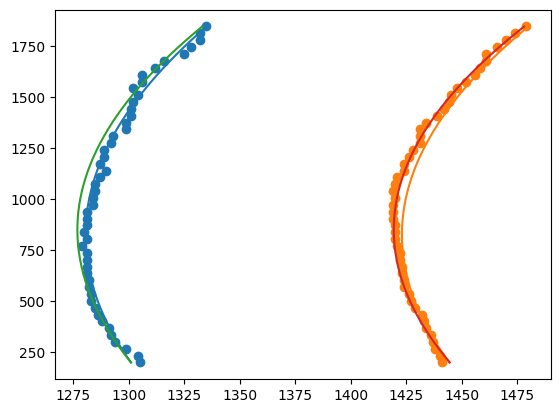

In [64]:

plt.scatter(peaks[:, 0], yvals)
plt.scatter(peaks[:, 1], yvals)

plt.plot(hyperbola(Econst1, yvals, *popt1), yvals)
#plt.plot(hyperbola(Econst2, yvals, *popt2), yvals)
plt.plot(hyperbola(Econst2, yvals, *popt1), yvals)

plt.plot(hyperbola(Econst1, yvals, *popt2), yvals)
plt.plot(hyperbola(Econst2, yvals, *popt2), yvals)

So, we are now getting good agreement. Important: Optimiser is bad at optimising $D$ to fit both lines, so it's better for me to choose it myself, to ensure accurate fitting to both lines. One extension might be to fir to both lines simultaneously (https://stackoverflow.com/questions/26242979/fit-multiple-parametric-curves-with-scipy) but this seems unnecessary for now.

## Creating a new energy map

In [108]:
from scipy import constants
from bragg import sobel_matrix, convolve_image, make_lineout, locate_peaks

class HypEnergyMap(object):

    def __init__(
        self,
        img: np.ndarray,
        num_lineout_points: int,
        dy: int,
        xavg_period: int,
        n_lines: int,
        min_sep: int,
        sobel_shape: tuple[int, int],
        energies: list[float],
    ):
        self.img = img.copy()
        self.dy = dy
        self.num_lineout_points = num_lineout_points
        self.xavg_period = xavg_period
        self.n_lines = n_lines
        self.min_sep = min_sep
        self.sobel_shape = sobel_shape
        self.energies = np.array(sorted(energies, reverse=True))
        self.centre: tuple[float, float] = None

        self.two_d = 15.96e-10
        self.k: float = constants.h * constants.c / (self.two_d * constants.e)
        self.hyp_params: np.ndarray = None

        self.sobel = sobel_matrix(sobel_shape)

        self.convolved_img = convolve_image(self.img, self.sobel)

        self.calculate_map_parameters()

        self.create_energy_map()

        # make sure r1, r2 and E1, E2 are in the correct order
        """if self.r1 > self.r2:
            self.r1, self.r2 = self.r2, self.r1
            """

        # self.create_energy_map()

    def calculate_map_parameters(self):

        # Take lineouts at a range of y values across the image

        yvals = np.linspace(self.dy, self.img.shape[0] - self.dy, self.num_lineout_points, dtype=int)

        lineouts = [make_lineout(self.convolved_img, y, self.dy, self.xavg_period) for y in yvals]

        # locate the peaks in each lineout

        peak_locs = np.array([locate_peaks(lineout, self.n_lines, self.min_sep)[0] for lineout in lineouts])

        # fit the hyperbolas to the peaks. For now, D is basically fixed to get the shape right
        p0 = [50, 750, 1.5e7, 0.2]
        bounds = ([-5000, 600, 1.4e7, 0], [1000, 1000, 1.5e7, 1])

        Econsts = self.energies**2 / self.k**2 - 1

        popt1, _ = curve_fit(
            lambda y, xc, yc, D2, Ys: hyperbola(Econsts[0], y, xc, yc, D2, Ys),
            yvals,
            peak_locs[:, 0],
            p0=p0,
            maxfev=10000,
            bounds=bounds
        )
        popt2, _ = curve_fit(
            lambda y, xc, yc, D2, Ys: hyperbola(Econsts[1], y, xc, yc, D2, Ys),
            yvals,
            peak_locs[:, 1],
            p0=p0,
            maxfev=10000,
            bounds=bounds
        )

        self.hyp_params = popt1

    
    def calculate_energy(self, loc: tuple[float, float]):
        """Calculate the energy at a given location"""

        xc, yc, D2, Ys = self.hyp_params

        y, x = loc

        return self.k * np.sqrt(1+(D2+Ys*(y-yc)**2)/((x-xc)**2))

    def create_energy_map(self):

        indices = np.indices(self.img.shape)

        self.energy_map: np.ndarray = self.calculate_energy(indices)

    def calibrate_energies(self, spectrum):
        """Use a spectrum to improve energy map calibration"""

    def get_energies(self, locs: np.ndarray):
        """Get energies from array positions"""
        energies = np.array([self.energy_map[int(loc[0]), int(loc[1])] for loc in locs])
        return energies

In [111]:
em = HypEnergyMap(spc.img, 50, 200, 20, 2, 100, (25, 25), energies)

hit_enegies = em.get_energies(spc.all_hit_locations)

1218.5


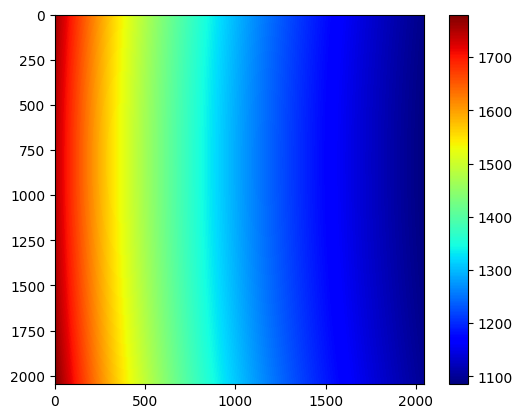

In [110]:
print(em.energies[0])
plt.imshow(em.energy_map, cmap="jet")
plt.colorbar()

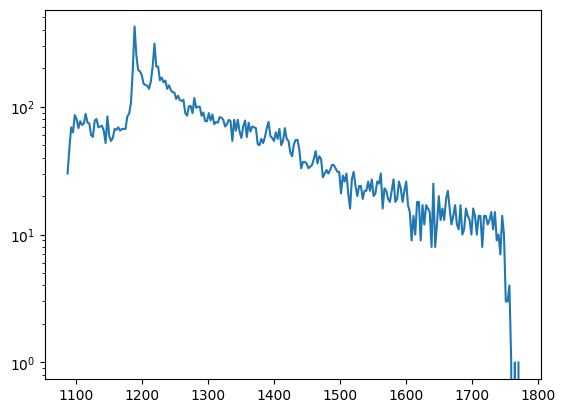

In [114]:
from histograms import make_histogram

bin_centers, hist = make_histogram(hit_enegies, 250)

plt.plot(bin_centers, hist)
plt.yscale("log")

In [1]:
from spc import SPC
import numpy as np
import matplotlib.pyplot as plt
from bragg import EnergyMap
image_nos = [1, 2, 4, 6, 7, 8, 11, 14, 16, 17, 19] # See Week 3
energies = [1218.5, 1188.0]
all_images = np.array([np.load(f'data/images/image{no}.npy') for no in image_nos])

spcs = []
hit_values = []
hit_locations = []


for i in range(len(all_images)):
    spc = SPC(all_images[i], 75, 30, 2)
    spcs.append(spc)
    hit_values.append(spc.all_hit_values)
    hit_locations.append(spc.all_hit_locations)
    print(f"Finished image {image_nos[i]}")

master_energy_map = EnergyMap(spcs[5].img, 200, 200, 20, 2, 100, (25, 25), energies)

Finished image 1
Finished image 2
Finished image 4
Finished image 6
Finished image 7
Finished image 8
Finished image 11
Finished image 14
Finished image 16
Finished image 17
Finished image 19


In [2]:
all_hit_energies = [master_energy_map.get_energies(hit_locs) for hit_locs in hit_locations]

C:\Users\jwbar\AppData\Local\Temp\ipykernel_6444\922973544.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("jet")


Text(0.5, 1.0, 'All spectra')

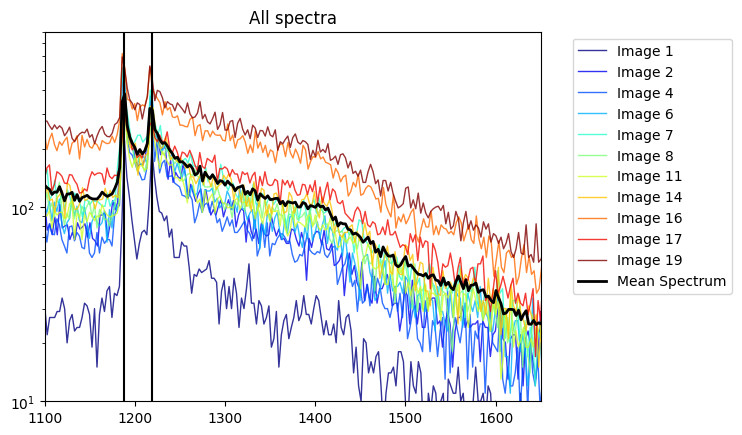

In [5]:
from histograms import make_histogram
import matplotlib
import matplotlib.pyplot as plt

cmap = matplotlib.cm.get_cmap("jet")

colours = [cmap(i) for i in np.linspace(0, 1, len(all_hit_energies))]

all_energy_spectra = []

all_hit_energies = sorted(all_hit_energies, key = lambda x: np.mean(x))

for i in range(len(all_hit_energies)):
    bin_centers, hist = make_histogram(all_hit_energies[i], 250)
    all_energy_spectra.append(hist)
    plt.plot(bin_centers, hist, label = f"Image {image_nos[i]}", c=colours[i], alpha = 0.8, lw = 1)

all_energy_spectra = np.array(all_energy_spectra)
mean_spectrum = np.mean(all_energy_spectra, axis=0)

plt.plot(bin_centers, mean_spectrum, label = "Mean Spectrum", c="black", lw=2)

plt.yscale("log")
plt.ylim(10,800)
#plt.vlines(energies, 0, 10000, colors='r')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(1100,1650)

plt.vlines(energies, 0, 10000, colors='black')

plt.title("All spectra")

# [#1](https://github.com/JackBarker7/B8_code/issues/1)
# Fixing double hit detection

We are seeing morme double hits than expected, so we need to change how we detect double hits. Lets start by looking at the histograms, and looking for the second peak

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from spc import SPC
from bragg import EnergyMap
from histograms import make_histogram

img = np.load("data/images/image8.npy")
pt = 75
spc = SPC(img, pt, 35, 2, True, image_indices=[(0, 2048), (0, 1200)])

Expected n2 = 10.03763916059261
n2 = 43


(0.0, 400.0)

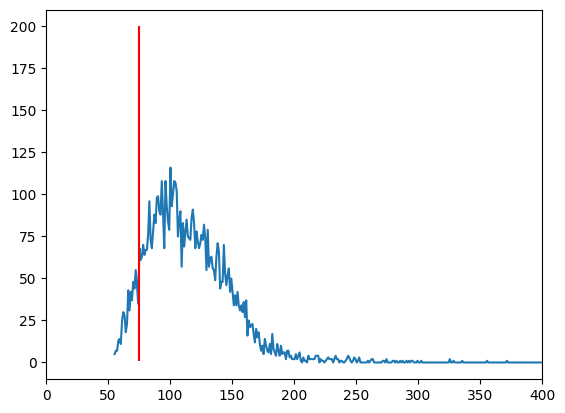

In [3]:
%matplotlib inline
bins, hist = make_histogram(spc.all_hit_values, -1)

n2 = spc.n_double_hits
n1 = spc.n_single_hits

print(f"Expected n2 = {n1**2/(2*((1200*2048)-n1))}")
print(f"n2 = {n2}")

plt.plot(bins, hist)
plt.vlines([pt], 1, 200, colors="r")
plt.xlim(0,400)


We're (or rather, we were) seeing way more double hits than expected. Let's plot the image, with all double hits highlighted, to see why we're seeing too many.

In [4]:
%matplotlib qt


def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((y-.5, x-.5), 1,1, fill=False, linewidth=2, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

plt.imshow(spc.img, cmap="jet")

for hit in spc.double_hit_locs:
    highlight_cell(*hit, edgecolor="r")

plt.show()


Added some more L shape variants, since fully secondary-pixel hits can split in wierder ways.

Also added requirement that double hits have to have at least one primary pixel.

Now, the above number looks much better, especially when we take into account the fact that double hits are more likely than predicted, due to charge spread (they do not have to perfectly hit the same pixel)

## Monte Carlo Simulation

We can do better by considering a Monte Carlo simulation of random hits, and seeing which ones overlap

In [13]:
n_hits = spc.n_single_hits + spc.n_double_hits

from monte_carlo_circles import monte_carlo

expected_n2 = monte_carlo(1200, 2048, np.sqrt(2/np.pi), n_hits, 20)

Trial: 1/20
Trial: 2/20
Trial: 3/20
Trial: 4/20
Trial: 5/20
Trial: 6/20
Trial: 7/20
Trial: 8/20
Trial: 9/20
Trial: 10/20
Trial: 11/20
Trial: 12/20
Trial: 13/20
Trial: 14/20
Trial: 15/20
Trial: 16/20
Trial: 17/20
Trial: 18/20
Trial: 19/20
Trial: 20/20


In [14]:
expected_n2

[80.25, 7.1545440106270926]

Which is within reason for what we see.

## Looking at the histogram

We're not really seeing the second peak clearly, so let's try combining SPC data from all the images

In [17]:
image_nos = [1, 2, 4, 6, 7, 8, 11, 14, 16, 17, 19] # See Week 3
energies = [1218.5, 1188.0]
all_images = np.array([np.load(f'data/images/image{no}.npy') for no in image_nos])

spcs = []
hit_values = []
hit_locations = []


for i in range(len(all_images)):
    spc = SPC(all_images[i], 75, 30, 2, True)
    spcs.append(spc)
    hit_values.append(spc.all_hit_values)
    hit_locations.append(spc.all_hit_locations)
    print(f"Finished image {image_nos[i]}")

Finished image 1
Finished image 2
Finished image 4
Finished image 6
Finished image 7
Finished image 8
Finished image 11
Finished image 14
Finished image 16
Finished image 17
Finished image 19


Expected n2 = 6048.796821847672
n2 = 3875


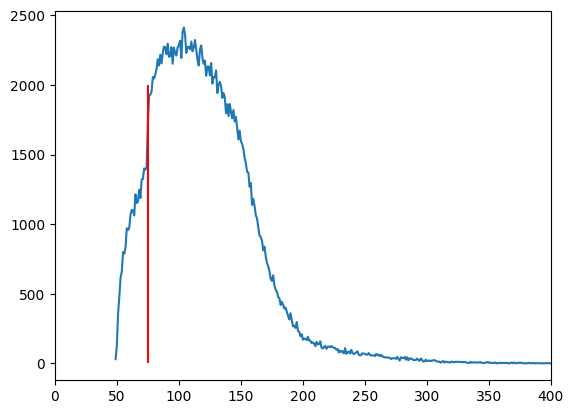

In [20]:
%matplotlib inline
from histograms import make_histogram
bins, hist = make_histogram(np.concatenate(hit_values), -1)

plt.plot(bins, hist)
#plt.yscale("log")
plt.xlim(0,400)
plt.vlines([75], 1, 2000, colors="r")

n2 = sum([spc.n_double_hits for spc in spcs])
n1 = sum([spc.n_single_hits for spc in spcs])

print(f"Expected n2 = {n1**2/(2*(2048**2-n1))}")
print(f"n2 = {n2}")

The main peak seems to be too wide to be able to see the second peak; the fact that we can't see it therefore does not cause me too much concern, since I'm confident in the way that I'm searching for double hits.

# Fitting to both lines at the same time

I want to optimise the fitting, to fit to both lines at once

In [1]:
from bragg import hyperbola
import scipy
import numpy as np
import matplotlib.pyplot as plt

from spc import SPC
from bragg import make_lineout, convolve_image, sobel_matrix, locate_peaks
img = np.load("data/images/image8.npy")

spc = SPC(img, 75, 30, 2)

convolved = convolve_image(spc.img, sobel_matrix((25, 25)))

dy = 200
xavg_period = 20

In [6]:

yvals = np.linspace(dy, spc.img.shape[0] - dy, 50, dtype=int)

lineouts = [make_lineout(convolved, y, dy, xavg_period) for y in yvals]

peaks = np.array([locate_peaks(lineout, 2, 100)[0] for lineout in lineouts])
peaks[:, 0]

array([1305, 1304, 1299, 1294, 1292, 1291, 1288, 1286, 1285, 1283, 1283,
       1282, 1282, 1281, 1281, 1281, 1281, 1279, 1281, 1280, 1281, 1281,
       1281, 1284, 1284, 1285, 1285, 1287, 1290, 1287, 1289, 1289, 1292,
       1293, 1299, 1299, 1301, 1301, 1302, 1304, 1302, 1306, 1306, 1312,
       1316, 1325, 1328, 1332, 1332, 1335], dtype=int64)

In [20]:
from scipy.optimize import least_squares
from scipy import constants

k = constants.h * constants.c / (15.96e-10 * constants.e)
energies = np.array([1218.5, 1188.0])
def least_sq(params, *args):

    # params is (xc, yc, D2, Ys)

    xc = params[0]
    yc = params[1]
    D2 = params[2]
    Ys = params[3]

    # args is (y, x, Econsts)

    y = args[0]
    x = args[1]
    Econsts = args[2]

    x1 = x[:len(y)]
    x2 = x[len(y):]
    
    x1fit = np.empty_like(x1)
    x2fit = np.empty_like(x2)


    x1fit = hyperbola(Econsts[0], y, xc, yc, D2, Ys)
    x2fit = hyperbola(Econsts[1], y, xc, yc, D2, Ys)

    return np.concatenate((x1fit, x2fit)) - x

p0 = [50, 750, 1.45e7, 0.2]
bounds = ([-5000, 600, 1.4e7, 0], [1000, 1000, 1.5e7, 1])

x = np.concatenate((peaks[:, 0], peaks[:, 1]))
y = yvals

print(x.shape, y.shape)

args = (y, x, energies**2 / k**2 - 1)

result = least_squares(least_sq, p0, args=args, bounds=bounds)

result.x

(100,) (50,)


array([-1.85853571e+03,  8.39386079e+02,  1.43860925e+07,  5.03403697e-01])

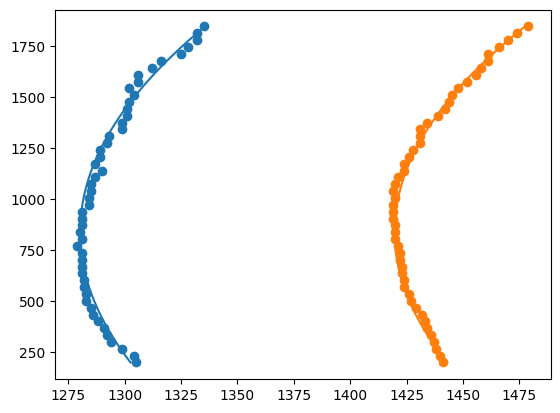

In [19]:
plt.scatter(peaks[:, 0], yvals)
plt.scatter(peaks[:, 1], yvals)
plt.plot(hyperbola(energies[0]**2 / k**2 - 1, yvals, *result.x), yvals)
plt.plot(hyperbola(energies[1]**2 / k**2 - 1, yvals, *result.x), yvals)

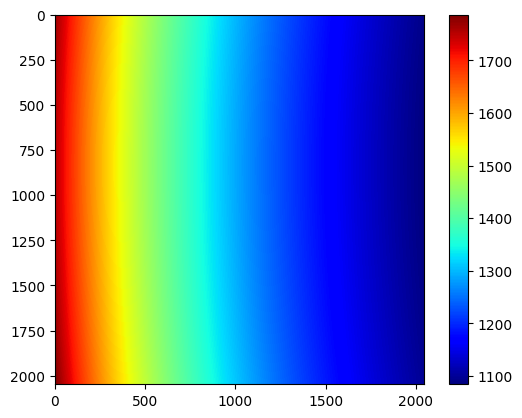

In [22]:
from bragg import EnergyMap

em = EnergyMap(spc.img, 200, 200, 20, 2, 100, (25, 25), energies)

plt.imshow(em.energy_map, cmap="jet")
plt.colorbar()

# Uncertainties and SNR


There are several sources of uncertainty in the energy spectrum:

- Calibration uncertainty: The Bragg peaks have a finite width, and so we cannot be completely sure what the energy is. There is also uncertainty in the fit parameters for the line, which we can determine.

- Hit uncertainty - We may detect a hit that is not there, or miss a hit (although this seems unlikely). Much more likely, we might mislabel a single hit as a double, or vice versa.

- Location/energy uncertainty: There is an uncertainty in the location of each hit, leading to an uncertainty in the energy of that hit.

All of these uncertainties manifest themselves as an uncertainty in how many hits shold be in each energy bin for the spectrum.

## Calibration uncertainty

We can estimate the uncertainty in fit parameters.

The covariance matrix is the inverse of the Hessian [[reference]](https://onlinelibrary.wiley.com/doi/pdf/10.1002/9780470824566.app1).

We can approximate the Hessian from the Jacobian using $H\approx J^T J$ [[reference]](https://math.stackexchange.com/questions/2349026/why-is-the-approximation-of-hessian-jtj-reasonable). (NB seems to be disagreement about whether to multiply this by 2 or not).

So, $\Sigma = (J^TJ)^{-1}$

NB the scipy docs for least_squares says "Modified Jacobian matrix at the solution, in the sense that J^T J is a Gauss-Newton approximation of the Hessian of the cost function. The type is the same as the one used by the algorithm"


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from spc import SPC
from bragg import EnergyMap
from histograms import make_histogram

img = np.load("data/images/image8.npy")

spc = SPC(img, 75, 30, 2, True)

em = EnergyMap(spc.img, 200, 200, 20, 2, 100, (25, 25), [1218.5, 1188.0])

print(em.hyp_params)
print(em.hyp_uncertainties)

print(f"Percentage errors: {em.hyp_uncertainties/em.hyp_params*100}")

[-1.85868103e+03  8.40896795e+02  1.43873833e+07  5.04991668e-01]
[2.30075778e+00 1.22660483e+00 2.06336798e+04 2.23661976e-03]
Percentage errors: [-0.12378443  0.14586865  0.1434151   0.44290231]


As expected, the fit is good, and the uncertainties are <1%, so can probably be ignored.

Likely a greater source of uncertainty is in the locations of the lines, due to their finite size. 

To see this, let's look at a lineout of the image, and the convolved image

In [4]:
from bragg import make_lineout, convolve_image, sobel_matrix

img = np.load("data/images/image8.npy")

spc = SPC(img, 75, 30, 2)

raw_lineout = make_lineout(spc.img, 1000, 200, 20)

convolved_lineout = make_lineout(convolve_image(spc.img, sobel_matrix((25,25))), 1000, 200, 20)

(1200.0, 1500.0)

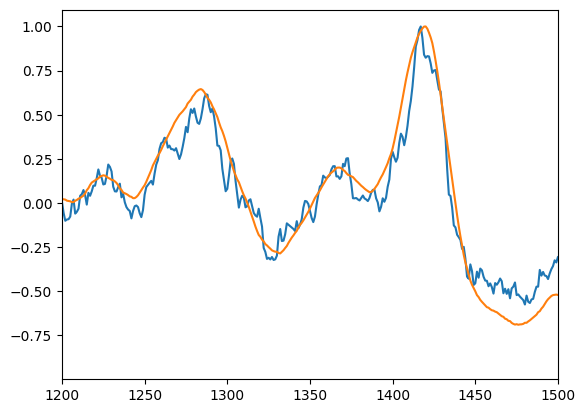

In [7]:
plt.plot(raw_lineout/raw_lineout.max())
plt.plot(convolved_lineout/convolved_lineout.max())
plt.xlim(1200,1500)

[39 27]


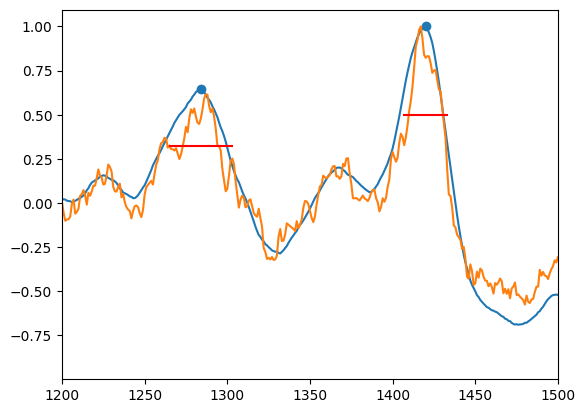

In [20]:
from bragg import locate_peaks
def fwhm(y, peak_loc, peak_height):
    """Find the full width at half maximum of a peak"""

    half_max = peak_height / 2

    left = np.where(y[:peak_loc] < half_max)[0][-1]
    right = np.where(y[peak_loc:] < half_max)[0][0] + peak_loc

    return right - left

peaks, heights = locate_peaks(convolved_lineout, 2, 100)
peaks

fwhms = np.array([fwhm(convolved_lineout, peak, height) for peak, height in zip(peaks, heights)])

plt.plot(convolved_lineout/convolved_lineout.max())
plt.plot(raw_lineout/raw_lineout.max())
plt.scatter(peaks, heights/convolved_lineout.max())
plt.hlines((heights/2)/convolved_lineout.max(), peaks - fwhms/2, peaks + fwhms/2, colors="r")
plt.xlim(1200,1500)

print(fwhms)

So, we can see that the FWHMs give a pretty good indication of our uncertainty in the location of the Bragg lines.

### Calculating an energy uncertainty

Ask Sam about this

## Uncertainty in heights of bins

We can more accurately determine hit locations (and hence energies) by fitting a Gaussian to the hit. This has the added advantage of providing an uncertainty in hit location.

(array([ 1.41943983,  1.78720882, -0.87773265,  1.78720881,  0.87773265]),
 array([0.21409177, 0.13343555, 0.13221365, 0.13343555, 0.13221365]))

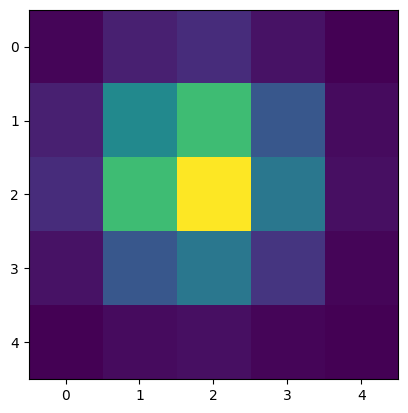

In [16]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def gaussian_2d(xy, a, mu_x, sigma_x, mu_y, sigma_y):
    x, y = xy
    return np.ravel(a * np.exp(-((x - mu_x)**2 / (2 * sigma_x**2))) * np.exp(-((y - mu_y)**2 / (2 * sigma_y**2))))

x, y = np.meshgrid(np.arange(5), np.arange(5))

z = np.array([
    [0,0,0,0,0],
    [0,1,1,0,0],
    [0,1,1,1,0],
    [0,0,1,0,0],
    [0,0,0,0,0]
])

p0 = [1, 2, 15, 2, 0.7]

popt, pcov = curve_fit(gaussian_2d, (x, y), z.ravel(), p0=p0)

plt.imshow(gaussian_2d((x, y), *popt).reshape(5,5))
popt, np.sqrt(np.diag(pcov))

This proves that it's possible, we now need to implement it. Let's take a 5x5 around each hit to do this

In [22]:
def gaussian_2d(xy, a, mu_x, sigma_x, mu_y, sigma_y):
    x, y = xy
    return np.ravel(a * np.exp(-((x - mu_x)**2 / (2 * sigma_x**2))) * np.exp(-((y - mu_y)**2 / (2 * sigma_y**2))))

def fit_hit(data: np.ndarray, centre_loc: tuple[int, int]) -> tuple[tuple[float, float], tuple[float, float]]:
    """Fits a 2D gaussian to a hit, given the 5x5 around the hit, and the location in
    the main image of the centre pixel of this 5x5

    centre_loc is in format (row, col)
    
    returns the centre of the Gaussian (in format (row, col)), and its uncertainty"""
    x, y = np.meshgrid(np.arange(5), np.arange(5))

    p0 = [data.max(), 2, 1, 2, 1] # assume hit is roughly at centre

    popt, pcov = curve_fit(gaussian_2d, (x, y), data.ravel(), p0=p0)

    u = np.sqrt(np.diag(pcov))

    return (centre_loc[0] - 2 + popt[3], centre_loc[1] - 2 + popt[1]), (u[3], u[1])



((2.000546066771156, 1.9994539332388703),
 (0.0169307061762454, 0.016930706122705284))

Determining the location of a double hit is alightly trickier. Since we see comparatively few double hits, doing this perfectly is not of great concern. Options are:

- Take the 2 highest values, (hoping that these are roughly where the 2 photns hit) and fit 5x5 Gaussians around both of these
    - Good: trats both hits as independent rather than the same, getting 2 locations
    - Bad: Both gaussians will likely converge on the same pixel, so we will need extra constraints. Also, will have issues if both photons hit the same pixel

- Just fit one Gaussian to the highest value
    - Good: simple, easy to implement
    - Bad: loses complexity of the double hit structure

Best is probably to fit 2 Gaussians. I will leave out constraints for now, since this would be more work to implement, and may actually cause more problems, since fitting may just converge to one of the bounds.

UPDATE: Fitting 2 Gaussians was causing convergence problems, since sometimes a relatively small value is chosen, so I'll just fit one for now.

### Checking the uncertainties

In [1]:
import numpy as np
from spc import SPC
from bragg import EnergyMap

img = np.load("data/images/image8.npy")
spc = SPC(img, 75, 30, 2, padding=2, fit_area_size=5)

spc.all_hit_locations

array([[1.02268433e+00, 1.38604669e+03],
       [1.88056658e+00, 5.97137547e+02],
       [2.09671346e+00, 1.46577975e+03],
       ...,
       [2.04616421e+03, 1.19749404e+03],
       [2.04632344e+03, 1.29019717e+03],
       [2.04673058e+03, 9.60029120e+02]])

In [3]:
sorted(spc.all_hit_uncertainties[:, 0], reverse=True)

[4.386658633291848,
 3.0945078357176157,
 0.7916797576170711,
 0.48681612749621234,
 0.440424549319093,
 0.37858487834954424,
 0.30514434593470613,
 0.3050722183477699,
 0.29804425602644646,
 0.28430304823777414,
 0.27611486450713885,
 0.27133446529476396,
 0.2635279546500962,
 0.25596457897190517,
 0.25483748256454725,
 0.2479545393328548,
 0.2446214572937491,
 0.24085953670422597,
 0.23660102472423522,
 0.2330320206918671,
 0.23261700092293863,
 0.22868478149594365,
 0.22858219641581762,
 0.22338631551480395,
 0.22165830767234937,
 0.2216231455984465,
 0.22007866450995714,
 0.2193857018485755,
 0.21520266684026954,
 0.21372865960674237,
 0.21337821619373823,
 0.21061709252498959,
 0.2105543644196126,
 0.21047072192833163,
 0.20938642839623467,
 0.209300841045914,
 0.20868221030938858,
 0.2075421689806831,
 0.2073602284053591,
 0.20697483333331176,
 0.20613078339519442,
 0.20613078339519442,
 0.20558676146306032,
 0.20305502843537854,
 0.20275026980092353,
 0.20056597695479944,
 0.200

### Looking at high uncertainty pixels

Some of the hits have strangely high uncertainties. Let's try and understand why. We are interested in ones that are of the order of pixels (since they are not anomalies, like the few that are hundreds of pixels)

[ 796.22261751 1607.07727841]
0.19932791250960563


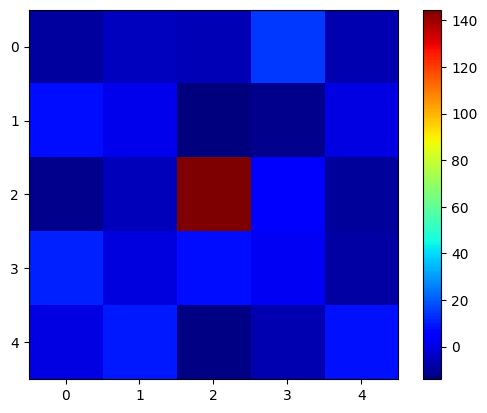

[679.17073873 612.00663659]
0.19946208339584648


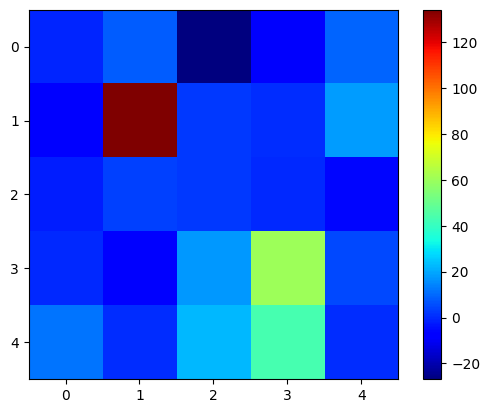

[1306.34176499 1581.75509297]
0.1996074023654192


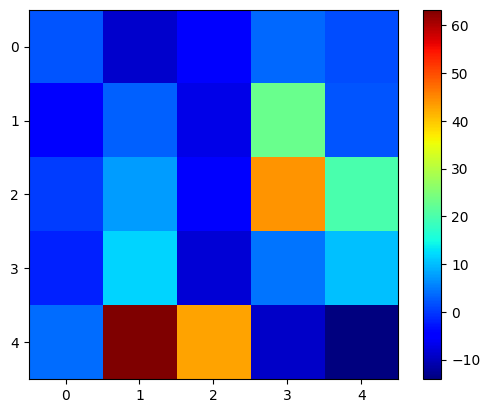

[1948.48076763 1478.11154363]
0.200112916442765


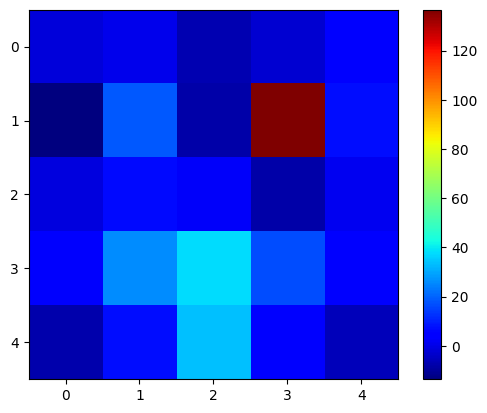

[355.20078572 595.19461053]
0.20056597695479944


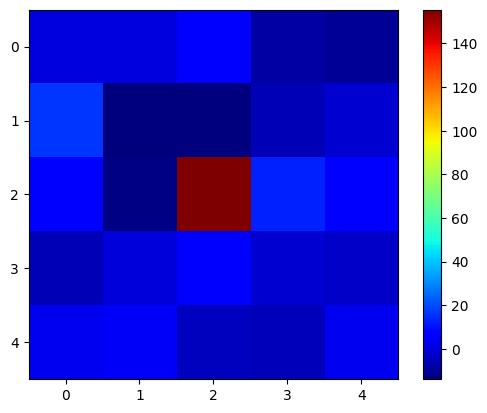

[ 922.30332163 1296.78231621]
0.20275026980092353


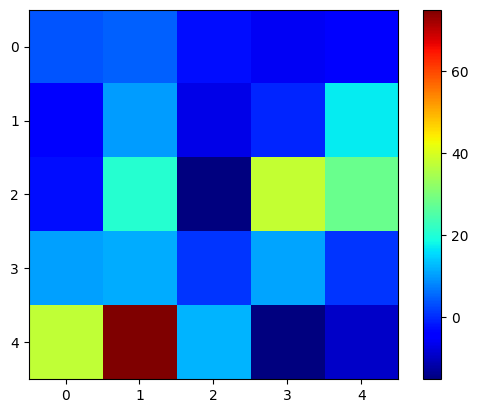

[ 642.03320409 1420.48891485]
0.20305502843537854


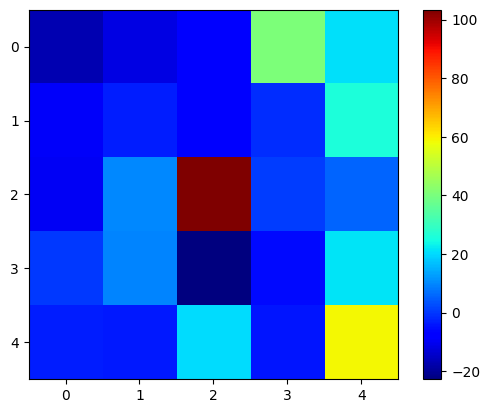

[200.82129256 663.16441901]
0.20558676146306032


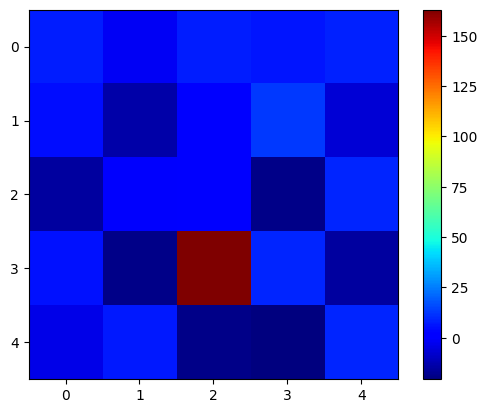

[1969.95412861  741.21987123]
0.20613078339519442


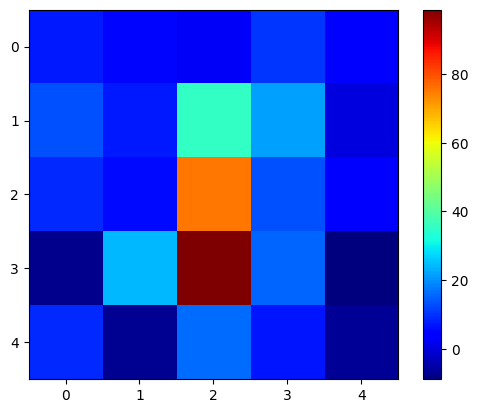

[1969.95412861  741.21987123]
0.20613078339519442


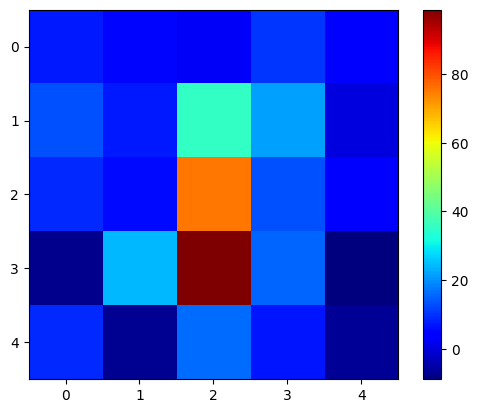

In [4]:
import matplotlib.pyplot as plt
interesting = sorted(spc.all_hit_uncertainties[:, 0])[-50:-40]
indices = np.array([np.where(spc.all_hit_uncertainties[:, 0] == i)[0][0] for i in interesting])

locations = spc.all_hit_locations[indices]

for i, loc in enumerate(locations):
    print(loc)
    print(interesting[i])

    loc = loc.astype(int)
    surroundings = spc.img[loc[0]-2:loc[0]+3, loc[1]-2:loc[1]+3]
    plt.imshow(surroundings, cmap="jet")
    plt.colorbar()
    plt.show()

In [28]:
locations

array([[1608.6064645 , 1390.70537728],
       [ 500.79713577,  610.07478099],
       [ 196.26407247,  667.31204323],
       [1981.22144201, 1083.216023  ],
       [1902.74207825, 1567.24780994],
       [1992.98519922, 1092.20750296],
       [1892.76620393, 1238.06834365],
       [ 791.30194512, 1579.63366713],
       [ 315.21351312, 1038.92190161],
       [1175.8239077 , 1048.03585438]])

In [3]:
real_uncertainties = [i for i in spc.all_hit_uncertainties if i[0] != 0]

print(f"medians: {np.median(real_uncertainties, axis=0)}")
print(f"bad fits: {len(spc.all_hit_uncertainties) - len(real_uncertainties)}")


medians: [0.13669497 0.13536403]
bad fits: 13


In [7]:
from spc import SPC
import numpy as np
import matplotlib.pyplot as plt
from bragg import EnergyMap
image_nos = [1, 2, 4, 6, 7, 8, 11, 14, 16, 17, 19] # See Week 3
energies = [1218.5, 1188.0]
all_images = np.array([np.load(f'data/images/image{no}.npy') for no in image_nos])

spcs = []
hit_values = []
hit_locations = []


for i in range(len(all_images)):
    spc = SPC(all_images[i], 75, 30, 2)
    spcs.append(spc)
    hit_values.append(spc.all_hit_values)
    hit_locations.append(spc.all_hit_locations)
    print(f"Finished image {image_nos[i]}")

master_energy_map = EnergyMap(spcs[5].img, 200, 200, 20, 2, 100, (25, 25), energies)

Finished image 1
Finished image 2
Finished image 4
Finished image 6
Finished image 7
Finished image 8
Finished image 11
Finished image 14
Finished image 16
Finished image 17
Finished image 19


In [10]:
all_hit_energies = [master_energy_map.get_energies(hit_locs) for hit_locs in hit_locations]

C:\Users\jwbar\AppData\Local\Temp\ipykernel_15436\1860921047.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("jet")


Text(0.5, 1.0, 'All spectra')

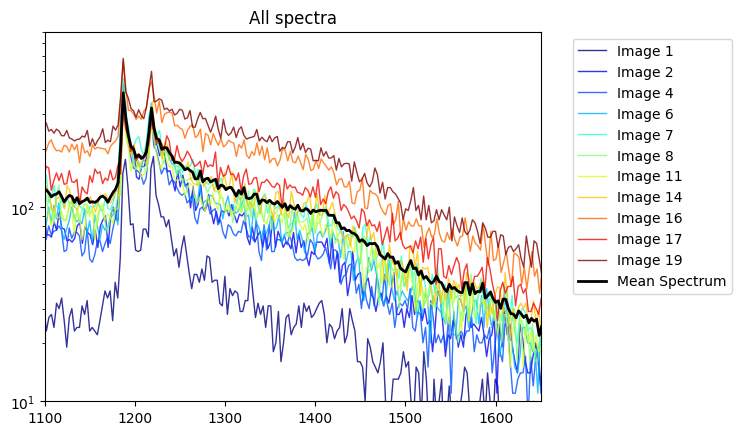

In [11]:
%matplotlib inline
from histograms import make_histogram
import matplotlib
import matplotlib.pyplot as plt

cmap = matplotlib.colormaps["jet"]

colours = [cmap(i) for i in np.linspace(0, 1, len(all_hit_energies))]

all_energy_spectra = []

all_hit_energies = sorted(all_hit_energies, key = lambda x: np.mean(x))

for i in range(len(all_hit_energies)):
    bin_centers, hist = make_histogram(all_hit_energies[i], 250)
    all_energy_spectra.append(hist)
    plt.plot(bin_centers, hist, label = f"Image {image_nos[i]}", c=colours[i], alpha = 0.8, lw = 1)

all_energy_spectra = np.array(all_energy_spectra)
mean_spectrum = np.mean(all_energy_spectra, axis=0)

plt.plot(bin_centers, mean_spectrum, label = "Mean Spectrum", c="black", lw=2)

plt.yscale("log")
plt.ylim(10,800)
#plt.vlines(energies, 0, 10000, colors='r')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(1100,1650)


plt.title("All spectra")